In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
path = '/Women_Dresses_Reviews_Dataset.csv'
data = pd.read_csv(path)

In [3]:
data.head(3)

,s.no,age,division_name,department_name,class_name,clothing_id,title,review_text,alike_feedback_count,rating,recommend_index
0,0,40,General,Bottoms,Jeans,1028,Amazing fit and wash,Like other reviewers i was hesitant to spend t...,0,5,1
1,1,62,General Petite,Tops,Blouses,850,Lovely and unique!,As is true of a bunch of the fall clothing pho...,12,5,1
2,2,47,General Petite,Bottoms,Skirts,993,Meh,"I so wanted this skirt to work, love the desig...",3,1,0


In [4]:
# Total 23486 records
data.shape

(23486, 11)

In [5]:
data.dtypes

s.no                     int64
age                      int64
division_name           object
department_name         object
class_name              object
clothing_id              int64
title                   object
review_text             object
alike_feedback_count     int64
rating                   int64
recommend_index          int64
dtype: object

In [6]:
# Missing values in each feature
data.isna().sum()

s.no                       0
age                        0
division_name             14
department_name           14
class_name                14
clothing_id                0
title                   3810
review_text              845
alike_feedback_count       0
rating                     0
recommend_index            0
dtype: int64

In [7]:
# Process the data
# Replace missing values in division_name, department_name and class_name
# Rename 'recommend_index ' to recommend_index
# Group the age 

data = (data
       .fillna({'division_name': 'Not_Known',
               'department_name': 'Not_Known',
               'class_name': 'Not_Known'})
       .rename(columns={'recommend_index ': 'recommend_index'})
       .assign(age_group=lambda x: pd.cut(data['age'], 
                                        bins=(0,19,29,39,49,59,69,np.inf), 
                                        labels=['Teen', '20-29', '30-39', '40-49', '50-59', '60-69', 'Above 70']
                                )
        )

)

In [8]:
data.head(2)

,s.no,age,division_name,department_name,class_name,clothing_id,title,review_text,alike_feedback_count,rating,recommend_index,age_group
0,0,40,General,Bottoms,Jeans,1028,Amazing fit and wash,Like other reviewers i was hesitant to spend t...,0,5,1,40-49
1,1,62,General Petite,Tops,Blouses,850,Lovely and unique!,As is true of a bunch of the fall clothing pho...,12,5,1,60-69


#### recommend_index is the label for this case study and dataset is imbalanced

In [9]:
print(data['recommend_index'].value_counts(), '\n')
print(f' recommended: {round((19314/data.shape[0])*100, 2)}% observations\n not_recommended: {round((4172/data.shape[0])*100, 2)}% observations')

1    19314
0     4172
Name: recommend_index, dtype: int64 

 recommended: 82.24% observations
 not_recommended: 17.76% observations


### Out of three know divisions, General division has highest sales, i.e 59%

In [10]:
division_sale = pd.DataFrame(data.groupby('division_name')['s.no'].count()).reset_index()
division_sale.rename(columns={'s.no': 'total_sales'}, inplace=True)
division_sale['percentage_sale'] = round(division_sale['total_sales'].apply(lambda x: (x/data.shape[0]) * 100), 2)
division_sale.drop(['total_sales'], axis=1, inplace=True)
division_sale

,division_name,percentage_sale
0,General,58.97
1,General Petite,34.57
2,Initmates,6.40
3,Not_Known,0.06


### Which age group buys more?

Text(0, 7, 'Woman in their thirties buy more. Teens and above 70 buy less')

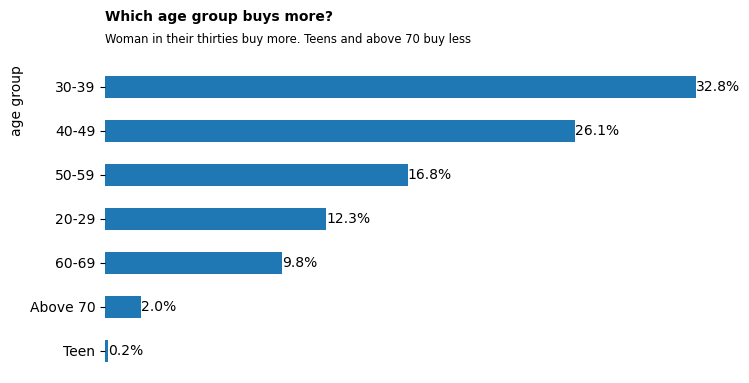

In [11]:
most_buying_age_group = data.groupby(['age_group'], as_index=False)['s.no'].count().sort_values(by='s.no')
most_buying_age_group.rename(columns={'s.no': 'percentage'}, inplace=True)
most_buying_age_group.set_index('age_group', inplace=True)

# Calculate percentage
most_buying_age_group = most_buying_age_group.div(data.shape[0]).mul(100).round(2)

# plot
plot1 = most_buying_age_group.plot( kind='barh', figsize=(8, 4))
for p in plot1.containers:
    plot1.bar_label(p, fmt='%.1f%%')


plt.box(False)
plt.xticks([])
plt.ylabel('age group', loc='top')
plt.legend('',frameon=False)
plt.text(x=0, y=7.5, s='Which age group buys more?', fontweight='bold')
plt.text(x=0, y=7, s='Woman in their thirties buy more. Teens and above 70 buy less', fontsize='small')

Text(0, 7, 'Except Teen, other age groups have similar buying behavior. Womans buy more tops and dresseses.')

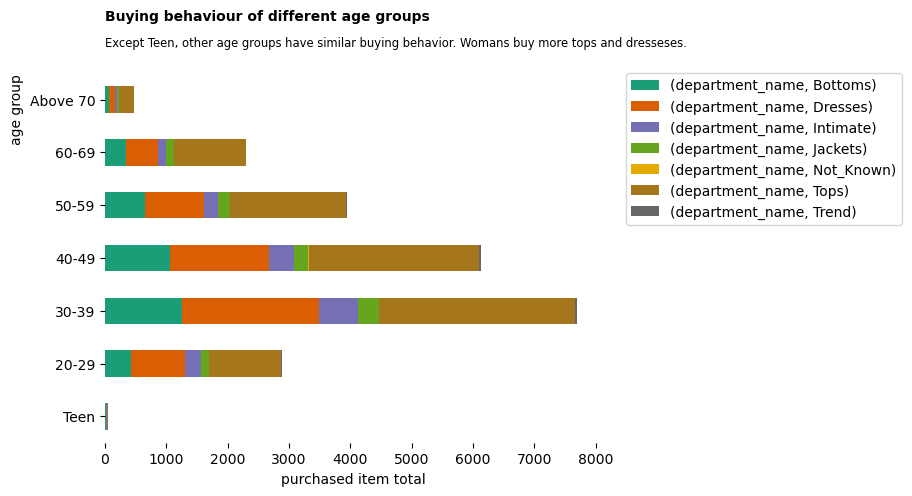

In [12]:
# What age group buys what kind of clothes?
pd.DataFrame(data.groupby('age_group')['department_name'].value_counts()).unstack().plot.barh(stacked=True, colormap='Dark2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
plt.box(False)
plt.xlabel('purchased item total',  loc='center')
plt.ylabel('age group', loc='top')
plt.text(x=0, y=7.5, s='Buying behaviour of different age groups', fontweight='bold')
plt.text(x=0, y=7, s='Except Teen, other age groups have similar buying behavior. Womans buy more tops and dresseses.', fontsize='small')

### Model: Classification problem

In [13]:
# I'm not considering title and review_text features for modeling as the dataset has feature called rating. 
data_mod = data.drop(columns=['title', 'review_text', 'clothing_id', 's.no', 'age_group'], axis=1)

In [14]:
data_mod.tail(2)

,age,division_name,department_name,class_name,alike_feedback_count,rating,recommend_index
23484,57,General,Dresses,Dresses,10,5,1
23485,56,General,Jackets,Jackets,0,5,1


In [15]:
# Encode categorical data
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

for col in data_mod.select_dtypes(include='O').columns:
    data_mod[col] = label_encoder.fit_transform(data_mod[col])

In [16]:
data_mod.head(3)

,age,division_name,department_name,class_name,alike_feedback_count,rating,recommend_index
0,40,0,0,7,0,5,1
1,62,1,5,0,12,5,1
2,47,1,0,16,3,1,0


In [17]:
# Split the data
# Challenge_1: Make sure train and test splits have the same ditribution as original dataset

from sklearn.model_selection import train_test_split

y = data_mod['recommend_index']
X = data_mod.drop(columns=['recommend_index'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, shuffle= True, stratify=y)

In [18]:
# As the dataset is imbalanced, I used stratify option to make sure the data distribution in train and test are similar

# Training data
print(y_train.value_counts(), '\n')
print(f' recommended: {round((14485/y_train.shape[0])*100, 2)}% observations\n not_recommended: {round((3129/y_train.shape[0])*100, 2)}% observations')

1    14485
0     3129
Name: recommend_index, dtype: int64 

 recommended: 82.24% observations
 not_recommended: 17.76% observations


In [19]:
# Testing data

print(y_test.value_counts(), '\n')
print(f' recommended: {round((4829/y_test.shape[0])*100, 2)}% observations\n not_recommended: {round((1043/y_test.shape[0])*100, 2)}% observations')

1    4829
0    1043
Name: recommend_index, dtype: int64 

 recommended: 82.24% observations
 not_recommended: 17.76% observations


In [20]:
# Challenge_2: Training data is still imbalanced: Peanalize the errors using class_weight
# model1 : RandomForestClassifier
# model2 : LogisticRegression

from sklearn.ensemble import RandomForestClassifier

model1 = RandomForestClassifier(n_estimators=10, class_weight='balanced')
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)


In [21]:
# Evaluate predictions

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

print(f'Precision: {round(precision_score(y_test, y_pred), 2)}')
print(f'F1 score: {round(f1_score(y_test, y_pred), 2)}')


Precision: 0.96
F1 score: 0.95


In [22]:
from sklearn.linear_model import LogisticRegression
model2 = LogisticRegression(solver='liblinear',  class_weight='balanced')

model2.fit(X_train, y_train)
y_hat = model2.predict(X_test)

print(f'Precision: {round(precision_score(y_test, y_hat), 2)}')
print(f'F1 score: {round(f1_score(y_test, y_hat), 2)}')

Precision: 0.99
F1 score: 0.96
